In [1]:
# Computations
import numpy as np
import pandas as pd

# Tools
import os
import datetime
import itertools
from googletrans import Translator
from langdetect import detect

# Sklearn
from sklearn.impute import SimpleImputer

# Visualisation libraries

## progressbar
import progressbar

## Text
from colorama import Fore, Back, Style
from IPython.display import Image, display, Markdown, Latex, clear_output

## seaborn
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("paper", rc={"font.size":12,"axes.titlesize":14,"axes.labelsize":12})

## matplotlib
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import matplotlib.colors as mcolors
from matplotlib.patches import Ellipse, Polygon
import matplotlib.gridspec as gridspec
from pylab import rcParams
plt.style.use('seaborn-whitegrid')
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (17, 6)
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['text.color'] = 'k'
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

<div class="alert alert-block alert-success">
<a href="https://hatefdastour.github.io/">Home</a> / 
<a href="https://hatefdastour.github.io/portfolio/financial_analysis_and_modeling/">Financial Analysis and Modeling</a>
</div>

## Predict Future Sales

* [<font color='Green'><b>Preprocessing</b></font>](https://hatefdastour.github.io/portfolio/financial_analysis_and_modeling/Predict_Future_Sales_Preprocessing.html)
* [**Exploratory Data Analysis**](https://hatefdastour.github.io/portfolio/financial_analysis_and_modeling/Predict_Future_Sales_EDA.html)
* [**Modeling: CatBoost Regressor**](https://hatefdastour.github.io/portfolio/financial_analysis_and_modeling/Predict_Future_Sales_Modeling_CatBoostReg.html)

<div class="alert alert-block alert-info">
<font size="+2.5"><b>
Predict Future Sales
</b></font>
</div>

In this article, we work with the [Predict Future Sales](https://www.kaggle.com/c/competitive-data-science-predict-future-sales/overview) provided by one of the largest Russian software firms - [1C Company](http://1c.ru/eng/title.htm). 


## Data Description

You are provided with daily historical sales data. The task is to forecast the total amount of products sold in every shop for the test set. Note that the list of shops and products slightly changes every month. Creating a robust model that can handle such situations is part of the challenge.

## File descriptions
sales_train.csv - the training set. Daily historical data from January 2013 to October 2015.
test.csv - the test set. You need to forecast the sales for these shops and products for November 2015.
sample_submission.csv - a sample submission file in the correct format.
items.csv - supplemental information about the items/products.
item_categories.csv  - supplemental information about the items categories.
shops.csv- supplemental information about the shops.

## Data fields

| Feature            | Description                                                                                                     |
|--------------------|-----------------------------------------------------------------------------------------------------------------|
| ID                 | An Id that represents a (Shop, Item) tuple within the test set                                                  |
| shop_id            | Unique identifier of a shop                                                                                     |
| item_id            | Unique identifier of a product                                                                                  |
| item_category_id   | Unique identifier of item category                                                                              |
| item_cnt_day       | The number of products sold. You are predicting a monthly amount of this measure                                |
| item_price         | Current price of an item                                                                                        |
| date               | Date in format dd/mm/yyyy                                                                                       |
| date_block_num     | A consecutive month number, used for convenience. January 2013 is 0, february 2013 is 1,..., October 2015 is 33 |
| item_name          | The name of item                                                                                                |
| shop_name          | The name of shop                                                                                                |
| item_category_name | The name of item category                                                                                       |

In [2]:
def Header(Text, L = 100, C = 'Blue', T = 'White'):
    BACK = {'Black': Back.BLACK, 'Red':Back.RED, 'Green':Back.GREEN, 'Yellow': Back.YELLOW, 'Blue': Back.BLUE,
         'Magenta':Back.MAGENTA, 'Cyan': Back.CYAN}
    FORE = {'Black': Fore.BLACK, 'Red':Fore.RED, 'Green':Fore.GREEN, 'Yellow':Fore.YELLOW, 'Blue':Fore.BLUE,
         'Magenta':Fore.MAGENTA, 'Cyan':Fore.CYAN, 'White': Fore.WHITE}
    print(BACK[C] + FORE[T] + Style.NORMAL + Text + Style.RESET_ALL + ' ' + FORE[C] +
          Style.NORMAL +  (L- len(Text) - 1)*'=' + Style.RESET_ALL)
    
def Line(L=100, C = 'Blue'):
    FORE = {'Black': Fore.BLACK, 'Red':Fore.RED, 'Green':Fore.GREEN, 'Yellow':Fore.YELLOW, 'Blue':Fore.BLUE,
         'Magenta':Fore.MAGENTA, 'Cyan':Fore.CYAN, 'White': Fore.WHITE}
    print(FORE[C] + Style.NORMAL + L*'=' + Style.RESET_ALL)

def Search_List(Key, List): return [s for s in List if Key in s]

PATH = '1c_software_dataset'
Files = os.listdir(PATH)
Files.remove('sample_submission.csv')
Files = np.sort(Files)
#
Files_Info = pd.DataFrame()
for i in range(len(Files)):
    # Read files
    Header(Files[i])
    filename = Files[i].split('.')[0]
    globals() [filename] = pd.read_csv(os.path.join(PATH, Files[i]))
    Temp = globals() [filename].shape
    Files_Info = Files_Info.append(pd.DataFrame({'File':[Files[i]], 'Number of Instances': [Temp[0]],
                                                 'Number of Attributes': [Temp[1]]}), ignore_index = True)
    # Datetime
    Cols = globals() [filename].columns
    DateTime = Search_List('date', Cols)
    if len(DateTime)>0:
        try: DateTime.remove('date_block_num')
        except: pass
        for c in DateTime:
            globals() [filename][c] = pd.to_datetime(globals() [filename][c]) 
            del c
    # Display
    display(globals() [filename].head(5))
Line()
display(Files_Info.style.hide_index())
Line()
del Files, i, Temp, filename, Cols, DateTime 

item_categories.csv ================================================================================


,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


item_categories_mod.csv ============================================================================


,Item Category Full,Item Category Full ID,Item Category,Item Category ID,Item Subcategory,Item Subcategory ID
0,PC - Headsets / Headphones,0,PC,0,Headsets / Headphones,0
1,Accessories - PS2,1,Accessories,1,PS2,1
2,Accessories - PS3,2,Accessories,1,PS3,2
3,Accessories - PS4,3,Accessories,1,PS4,3
4,Accessories - PSP,4,Accessories,1,PSP,4


items.csv ==========================================================================================


,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


items_mod.csv ======================================================================================


,Item Name,Item ID,Item Category Full ID
0,ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.),0,40
1,ABBYY FineReader 12 Professional Edition Full ...,1,76
2,В ЛУЧАХ СЛАВЫ (UNV),2,40
3,ГОЛУБАЯ ВОЛНА (Univ),3,40
4,КОРОБКА (СТЕКЛО),4,40


sales_train.csv ====================================================================================


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-02-01,0,59,22154,999.00,1.0
1,2013-03-01,0,25,2552,899.00,1.0
2,2013-05-01,0,25,2552,899.00,-1.0
3,2013-06-01,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0


sales_train_mod.csv ================================================================================


,Date,Date Block Number,Shop ID,Item ID,Item Price,Item Count Day,Revenue
0,2013-02-01,0,59,22154,999.00,1.0,999.00
1,2013-03-01,0,25,2552,899.00,1.0,899.00
2,2013-05-01,0,25,2552,899.00,-1.0,-899.00
3,2013-06-01,0,25,2554,1709.05,1.0,1709.05
4,2013-01-15,0,25,2555,1099.00,1.0,1099.00


shops.csv ==========================================================================================


,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


shops_mod.csv ======================================================================================


,Shop Name,Shop ID,City,City ID
0,"Yakutsk Ordzhonikidze, 56 fran",0,Yakutsk,0
1,"Yakutsk shopping center ""Central"" fran",1,Yakutsk,0
2,"Adygea TC ""Mega""",2,Adygea,1
3,Balashikha shopping and entertainment complex ...,3,Balashikha,2
4,"Volga shopping center ""Volga Mall""",4,Volga,3


test.csv ===========================================================================================


,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


test_mod.csv =======================================================================================


,ID,Shop ID,Item ID
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


File,Number of Instances,Number of Attributes
item_categories.csv,84,2
item_categories_mod.csv,84,6
items.csv,22170,3
items_mod.csv,22170,3
sales_train.csv,2935849,6
sales_train_mod.csv,2935849,7
shops.csv,60,2
shops_mod.csv,57,4
test.csv,214200,3
test_mod.csv,214200,3


# Preprocessing
## Translations

In [3]:
translator = Translator(service_urls=['translate.google.ca'])
# items -------------------------------------------------------------------------------
Orig_Names = items['item_name'].tolist()
Batch = 100
Intervals = list(np.arange(start = 0, stop = items.shape[0], step = Batch, dtype = int))
Intervals.append(items.shape[0])
Names = []

items['item_name'] = items['item_name'].map(lambda x: x.replace('!','').replace('*','').replace('/','').replace(' D','').strip())
# Counter = 0
# Progress_Bar = progressbar.ProgressBar(maxval = len(Intervals),
#                                        widgets=[progressbar.Bar('=', '|', '|'), progressbar.Percentage()])
# Progress_Bar.start()
# for L, R in zip(Intervals[:-1], Intervals[1:]):
#     Temp = translator.translate(Orig_Names[L:R], src='ru', dest='en')
#     Names.extend([x.text for x in Temp])
#     del Temp
#     Progress_Bar.update(Counter)
#     Counter+=1
# Progress_Bar.finish()

# items['item_name'] = Names
# del Orig_Names, Names

## item_categories -------------------------------------------------------------------------------
Temp = item_categories['item_category_name'].tolist()
Temp = translator.translate(Temp, src='ru', dest='en')

item_categories_dict = {}
for t in Temp:
    item_categories_dict[t.origin] = t.text
del t, Temp

item_categories['item_category_name'] = item_categories['item_category_name'].replace(item_categories_dict)

## shops -------------------------------------------------------------------------------
Temp = shops['shop_name'].tolist()
Temp = translator.translate(Temp, src='ru', dest='en')

shops_dict = {}
for t in Temp:
    shops_dict[t.origin] = t.text
del t, Temp

shops['shop_name'] = shops['shop_name'].replace(shops_dict)

items_mod = items.copy()
item_categories_mod = item_categories.copy()
shops_mod = shops.copy()
del items, item_categories, shops

## Modifications

In [4]:
def Cols_rename(Cols):
    return [x.replace('_',' ').title().replace('Id','ID').replace('Cnt','Count').replace('Num','Number') for x in Cols]

### Items

In [5]:
items_mod.columns = Cols_rename(items_mod.columns)
items_mod = items_mod.rename(columns= {'Item Category ID':'Item Category Full ID'})

### Item Categories

In [6]:
item_categories_mod.columns = ['Item Category Full', 'Item Category Full ID']
item_categories_mod['Item Category'] = item_categories_mod['Item Category Full'].str.split(' - ').map(lambda x: x[0].strip())
item_categories_mod['Item Category ID'], _ = pd.factorize(item_categories_mod['Item Category'])
item_categories_mod['Item Subcategory'] = item_categories_mod['Item Category Full'].str.split(' - ').map(lambda x: ', '.join(x[1:]))
item_categories_mod['Item Category'] = item_categories_mod['Item Category'].map(lambda x: x.title().replace('Pc', 'PC'))
Temp = item_categories_mod.loc[item_categories_mod['Item Subcategory'] == '', 'Item Category'].tolist()
item_categories_mod.loc[item_categories_mod['Item Subcategory'] == '', 'Item Subcategory'] = Temp
del Temp
item_categories_mod['Item Subcategory ID'], _ = pd.factorize(item_categories_mod['Item Subcategory'])

### Shops

In [7]:
shops_mod.columns = Cols_rename(shops_mod.columns)
Shops = shops_mod['Shop Name'].unique().tolist()
New_List = []
Replace_dict={'! ':'', '²':'', '?':''}
for S in Shops:
    for x, y in zip(Replace_dict.keys(),Replace_dict.values()):
        S = S.replace(x, y)
    New_List.append(S)
    
Replace_dict={}
for x, y in zip(Shops, New_List):
    Replace_dict[x] = y
    
shops_mod['Shop Name'] = shops_mod['Shop Name'].map(Replace_dict)
del Shops, New_List, Replace_dict, x, y, S

Moreover, looking into the shops_mod dataset, we can identify the following duplicated rows.

In [8]:
Shops_Replace_dict = {'''Rostov On Don shopping and entertainment complex "Megacenter Horizon" Island''' :
                      '''Rostov On Don shopping and entertainment complex "Megacenter Horizon"''', 40:39, 11:10,
                      '''Yakutsk shopping center "Central"''':'''Yakutsk shopping center "Central" fran''', 58:1}
shops_mod = shops_mod.replace(Shops_Replace_dict).drop_duplicates().sort_values(by = ['Shop ID'])

City

In [9]:
shops_mod['City'] = shops_mod['Shop Name'].str.split(' ').map(lambda x: x[0])
Temp = {'N.':'Nizhny Novgorod', 'N.Novgorod':'Nizhny Novgorod', 'SPb':'Other', 'Emergency':'Other',
        'Ufa':'Other', 'Digital':'Other', 'Outbound':'Other', 'RostovNaDon':'Rostov'}
shops_mod['City'] = shops_mod['City'].replace(Temp)
del Temp
shops_mod['City ID'], _ = pd.factorize(shops_mod['City'])

### Sales Train

In [10]:
sales_train.columns = Cols_rename(sales_train.columns)
sales_train_mod = sales_train.copy()
del sales_train

Let's take a look at **Item Count Day** and **Item Price**.

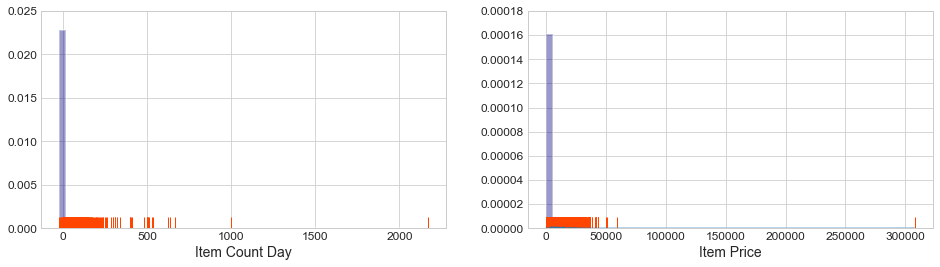

In [11]:
Columns = ['Item Count Day', 'Item Price']
Lims = [25e-3, 18e-5]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (16, 4))
ax = ax.ravel()
for i in range(len(Columns)):
    _ = sns.distplot(sales_train_mod[Columns[i]], rug=True, rug_kws={"color": "OrangeRed"},
                     hist_kws={"linewidth": 2, "alpha": .4, "color": "Navy"}, ax= ax[i])
    _ = ax[i].set_ylim([0, Lims[i]])

As can be seen, there are a few instances that need to be adjusted. Moreover, there the items with a negative number as price.
For these instances, we have,

In [12]:
sales_train_mod.loc[sales_train_mod['Item Price'] <0, 'Item Price'] = np.nan
for i in range(len(Columns)):
    m = sales_train_mod[Columns[i]].max()
    sales_train_mod.loc[sales_train_mod[Columns[i]] == m, Columns[i]]  = np.nan
    imp = SimpleImputer(missing_values=np.nan, strategy='median')
    sales_train_mod[Columns[i]] = imp.fit_transform(sales_train_mod[Columns[i]].values.reshape(-1,1))

Now,

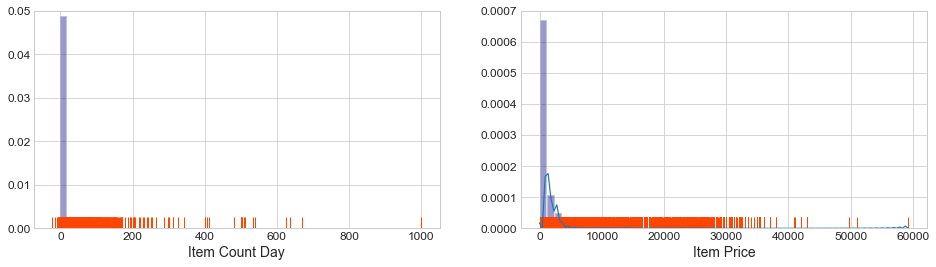

In [13]:
Lims = [5e-2, 7e-4]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (16, 4))
ax = ax.ravel()
for i in range(len(Columns)):
    _ = sns.distplot(sales_train_mod[Columns[i]], rug=True, rug_kws={"color": "OrangeRed"},
                     hist_kws={"linewidth": 2, "alpha": .4, "color": "Navy"}, ax= ax[i])
    _ = ax[i].set_ylim([0, Lims[i]])
del ax, fig, Lims, Columns

Moreover, the **Shop ID** needes to be adjusted here as well.

In [14]:
Shops_Replace_dict = {40:39, 11:10, 58:1}
sales_train_mod['Shop ID'] = sales_train_mod['Shop ID'].replace(Shops_Replace_dict)

Revenue,

In [15]:
sales_train_mod['Revenue'] = sales_train_mod['Item Count Day'] * sales_train_mod['Item Price']

Finally, the datetime.

In [16]:
sales_train_mod['Date'] = pd.to_datetime(sales_train_mod['Date'])

# Test

In [17]:
test_mod = test.copy()
test_mod.columns = Cols_rename(test_mod.columns)
test_mod['Shop ID'] = test_mod['Shop ID'].replace(Shops_Replace_dict)

## Saving to CSV files

In [18]:
items_mod.to_csv (PATH + '/items_mod.csv', index = None, header=True)
item_categories_mod.to_csv (PATH + '/item_categories_mod.csv', index = None, header=True)
shops_mod.to_csv (PATH + '/shops_mod.csv', index = None, header=True)
sales_train_mod.to_csv (PATH + '/sales_train_mod.csv', index = None, header=True)
test_mod.to_csv (PATH + '/test_mod.csv', index = None, header=True)

***
# References

1. [Kaggle Dataset: Predict Future Sales](https://www.kaggle.com/c/competitive-data-science-predict-future-sales/overview)

***